In [52]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
five_yrs_ago = date.today() - relativedelta(years=5)

In [188]:
df= yf.download('TATAmOTORS.NS', start=five_yrs_ago.strftime("%Y-%m-%d"), end= date.today().strftime("%Y-%m-%d"))
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-28,385.850006,387.399994,378.299988,379.299988,379.299988,4403872
2017-08-29,379.000000,382.350006,374.450012,376.100006,376.100006,4689547
2017-08-30,380.850006,382.750000,377.450012,378.500000,378.500000,3734824
2017-08-31,380.049988,380.450012,375.799988,376.549988,376.549988,4685511
2017-09-01,379.350006,392.850006,378.649994,390.850006,390.850006,7380325


In [189]:
df= df.loc[:, 'Low']
df

Date
2017-08-28    378.299988
2017-08-29    374.450012
2017-08-30    377.450012
2017-08-31    375.799988
2017-09-01    378.649994
                 ...    
2022-08-19    468.100006
2022-08-22    452.549988
2022-08-23    447.600006
2022-08-24    457.700012
2022-08-25    457.399994
Name: Low, Length: 1236, dtype: float64

In [190]:
df= df.values.reshape(-1,1)
df_train, df_valid, df_test= df[:int(0.6*len(df)),0], df[int(0.6*len(df)):int(0.8*len(df)),0], df[int(0.8*len(df)):,0]
len(df_test)

248

In [191]:
from sklearn.preprocessing import MinMaxScaler

In [192]:
scaler= MinMaxScaler(feature_range=(-1,1))
scaled_df= scaler.fit_transform(df)

In [193]:
x_train= []
y_train= []
time_step= 100
for i in range(time_step, len(df_train)):
    x_train.append(scaled_df[i-time_step:i,0])
    y_train.append(scaled_df[i,0])

In [194]:
x_train, y_train= np.array(x_train), np.array(y_train)

In [195]:
x_train= np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))


In [196]:
import torch
import torch.nn as nn

In [197]:
device= torch.device('cuda')

In [198]:
x_train= torch.from_numpy(x_train).type(torch.Tensor)
y_train= torch.from_numpy(y_train).type(torch.Tensor)

In [199]:
y_train.shape
y_train= np.reshape(y_train, (y_train.shape[0], 1))

In [200]:
input_dim=1
hidden_dim_lstm= 16
num_layers_lstm= 3         #number of stacks of lstm
output_dim= 1
epochs_lstm= 1000

In [201]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim= hidden_dim
        self.num_layers= num_layers
        self.lstm= nn.LSTM(input_dim, hidden_dim, num_layers, batch_first= True)
        self.fc= nn.Linear(hidden_dim, output_dim)          #fully connected layer after lstm
    def forward(self, x):
        h0= torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()               #.requires_grad is for computing gradients
        c0= torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn,cn)= self.lstm(x, (h0.detach(), c0.detach()))
        out= self.fc(out[:,-1,:])           #This represents the final state of the lstm as the output.
        return out

In [202]:
model_lstm= LSTM(input_dim= input_dim, hidden_dim= hidden_dim_lstm, output_dim= output_dim, num_layers= num_layers_lstm)
criterion= torch.nn.MSELoss(reduction= 'mean')
optimizer= torch.optim.Adam(model_lstm.parameters(), lr= 0.01)

In [203]:
model_lstm.cuda()

LSTM(
  (lstm): LSTM(1, 16, num_layers=3, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [204]:
for e in range(epochs_lstm):
    y_train_pred= model_lstm(x_train.cuda())
    loss= criterion(y_train_pred, y_train.cuda())
    optimizer.zero_grad()
    loss.backward()         #Backpropogation
    optimizer.step()        #Gradient descent step

In [205]:
model_lstm.train()

LSTM(
  (lstm): LSTM(1, 16, num_layers=3, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [206]:
#torch.save(model_lstm, 'Price_Pred_LSTM.pt')

In [207]:
valid_input= scaled_df[len(df)-len(df_valid)-time_step:len(df)-len(df_test),0]

In [208]:
valid_input.shape

(99,)

In [209]:
# x_valid=[]
# for i in range(time_step, len(valid_input)):
#     print(valid_input.iloc[i-time_step:i])
#     x_valid.append(valid_input[i-time_step:i])
# x_valid= np.array(x_valid)
# print(x_valid.shape)
# x_valid= torch.from_numpy(np.reshape(x_valid,(x_valid.shape[0], x_valid.shape[1],1))).type(torch.Tensor)

In [210]:
test_input= scaled_df[len(df)-len(df_test)-time_step:,0]

In [211]:
test_input.shape

(348,)

In [212]:
x_test=[]
for i in range(time_step, len(test_input)):
    x_test.append(test_input[i-time_step:i])
x_test= np.array(x_test)
print(x_test.shape)
x_test= torch.from_numpy(np.reshape(x_test,( x_test.shape[0], x_test.shape[1],1))).type(torch.Tensor)

(248, 100)


In [213]:
type(list(x_test))

list

In [214]:
from sklearn.metrics import r2_score

def plot_graph(df_type, x_type, model_lstm):
    pred= scaler.inverse_transform(model_lstm(x_type.cuda()).cpu().detach().numpy())
    plt.plot(df_type, color= 'green', label='Real')
    plt.plot(pred, color= 'red', label='Predicted')
    #print(r2_score(pred[:-1],df_type[1:]))

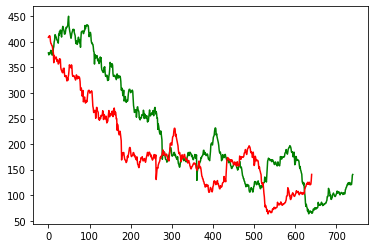

In [215]:
plot_graph(df_train, x_train, model_lstm)

In [216]:
#plot_graph(df_valid, x_valid)

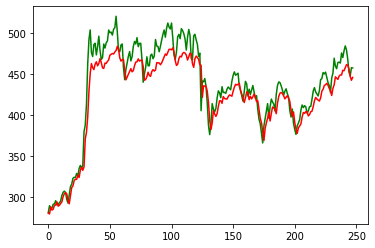

In [217]:
plot_graph(df_test, x_test, model_lstm)

In [218]:
#print(f'Tomorrow\'s price will be {pred_lstm[-1,0]}')

In [219]:
#model= torch.load('Price_Pred_LSTM.pt')

In [220]:
x_forecast= np.array(x_test)[-1].reshape((1,100,1))
forecast_lst=[]
x= torch.from_numpy(x_forecast).type(torch.Tensor)
for i in range(time_step):
    forecast= scaler.inverse_transform(model_lstm(x.cuda()).cpu().detach().numpy())
    x= x.numpy()
    x[0]= scaler.inverse_transform(x[0])
    y= x[0,1:]
    y= np.append(y, forecast)
    x[0]= y.reshape(100,1)
    forecast_lst.append(forecast[0,0])
    x[0]= scaler.transform(x[0])
    x= torch.from_numpy(x).type(torch.Tensor)

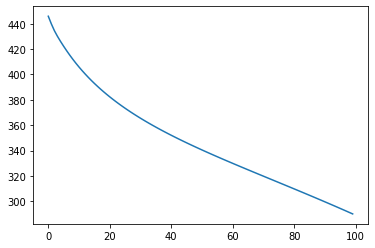

In [221]:
plt.plot(forecast_lst)